<a href="https://colab.research.google.com/github/changhyun-cho/astrophysics/blob/master/correlations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A global optical / X-ray correlation from XRBs to AGN

## Import Packages

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
import matplotlib
import matplotlib.pyplot as plt
from google.colab import drive

# %matplotlib inline

# drive.mount('/content/drive')
drive.mount("/content/drive/", force_remount=True)
# drive.flush_and_unmount()

Mounted at /content/drive/


In [ ]:
# Size (only for notebook)
plt.rcParams["figure.figsize"] = [10, 10]
colors = matplotlib.cm.Set1(np.linspace(0, 1, 8))

## X-Ray Binaries

### GROJ1655

In [ ]:
# read the file
groj = pd.read_csv(
    "/content/drive/My Drive/Research/NYU Abu Dhabi/correlations/GROJ1655.dat", sep="\t"
)
groj = groj.dropna()
groj["Target"] = "GROJ1655"

# add lag (in hour)
groj["Lag"] = 15  # sec
groj["Lag"] /= 3600  # hour

# change units and calculate
groj["L_x"] = 10 ** groj["log(Lx_bol)"]
groj["L_opt"] = 10 ** groj["log(L_opt)"]
groj["sqrt(L_x) a"] = np.sqrt(groj["L_x"]) * groj["Lag"]

# extract
groj = groj[["Target", "sqrt(L_x) a", "L_opt", "L_x"]]

# make a total data frame
df = groj[["Target", "sqrt(L_x) a", "L_opt", "L_x"]]

### GX339

In [ ]:
# read the file
gx = pd.read_csv(
    "/content/drive/My Drive/Research/NYU Abu Dhabi/correlations/gx339-4_hard.csv"
)
gx = gx.dropna()

gx["Target"] = "GX339"

# add lag (in hour)
gx["Lag"] = 10  # sec
gx["Lag"] /= 3600  # hour

# change units and calculate
gx["L_x"] = 10 ** gx["log(Lx_bol)"]
gx["L_opt"] = 10 ** gx["log(L_opt)"]
gx["sqrt(L_x) a"] = np.sqrt(gx["L_x"]) * gx["Lag"]

# extract
gx = gx[["Target", "sqrt(L_x) a", "L_opt", "L_x"]]
gx
# merge
df = pd.merge(df, gx, how="outer")
# df

### XTEJ1118

In [ ]:
# read the file
xtej = pd.read_csv(
    "/content/drive/My Drive/Research/NYU Abu Dhabi/correlations/XTEJ1118.dat", sep="\t"
)
xtej = xtej.dropna()
xtej["Target"] = "XTEJ1118"

# add lag (in hour)
xtej["Lag"] = 3  # sec
xtej["Lag"] /= 3600  # hour

# change units and calculate
xtej["L_x"] = 10 ** xtej["log(Lx_bol)"]
xtej["L_opt"] = 10 ** xtej["log(L_opt)"]
xtej["sqrt(L_x) a"] = np.sqrt(xtej["L_x"]) * xtej["Lag"]

# extract
xtej = xtej[["Target", "sqrt(L_x) a", "L_opt", "L_x"]]

# merge
df = pd.merge(df, xtej, how="outer")
# df

## AGN

### Temporary part (Import data directly from Excel)

In [ ]:
# read AGN data
agn = pd.read_csv(
    "/content/drive/My Drive/Research/NYU Abu Dhabi/correlations/agn_data.csv"
)
agn["Target"] = agn["targets"]
agn["Lag"] = agn["Lags(hour)"]

# change units and calculate
agn["L_x"] = 10 ** agn["log(Lx_bol)"]
agn["L_opt"] = 10 ** agn["log(L_opt)"]
agn["sqrt(L_x) a"] = np.sqrt(agn["L_x"]) * agn["Lag"]

# extract
agn = agn[["Target", "sqrt(L_x) a", "L_opt", "L_x"]]

# merge
df = pd.merge(df, agn, how="outer")
# df

### NGC4593

In [ ]:
n4593 = agn[agn["Target"] == "NGC4593"]
# n4593

### NGC4151

In [ ]:
n4151 = agn[agn["Target"] == "NGC4151"]
# n4151

### NGC3516

In [ ]:
n3516 = agn[agn["Target"] == "NGC3516"]
# n3516

### NGC4051

In [ ]:
n4051 = agn[agn["Target"] == "NGC4051"]
# n4051

### NGC2617

In [ ]:
n2617 = agn[agn["Target"] == "NGC2617"]
# n2617

### NGC5548 (Removing Host Galaxy Contribution)

#### 1. Download data from the archive



In [ ]:
df

,Target,sqrt(L_x) a,L_opt,L_x
0,GROJ1655,5.523008e+15,3.426936e+34,1.757008e+36
1,GROJ1655,1.443910e+16,3.096749e+34,1.200888e+37
2,GROJ1655,1.825445e+16,7.360477e+34,1.919377e+37
3,GROJ1655,1.918578e+16,8.296711e+34,2.120223e+37
4,GROJ1655,2.195302e+16,4.601569e+34,2.775946e+37
...,...,...,...,...
512,NGC4151,2.966305e+22,1.180198e+42,1.321452e+43
513,NGC4151,2.989183e+22,1.143274e+42,1.341914e+43
514,NGC4151,3.084107e+22,1.244223e+42,1.428495e+43
515,NGC4151,3.169435e+22,1.239114e+42,1.508632e+43


## Plots and Fittings

(1.0173048495838926, 18.97793516802148)

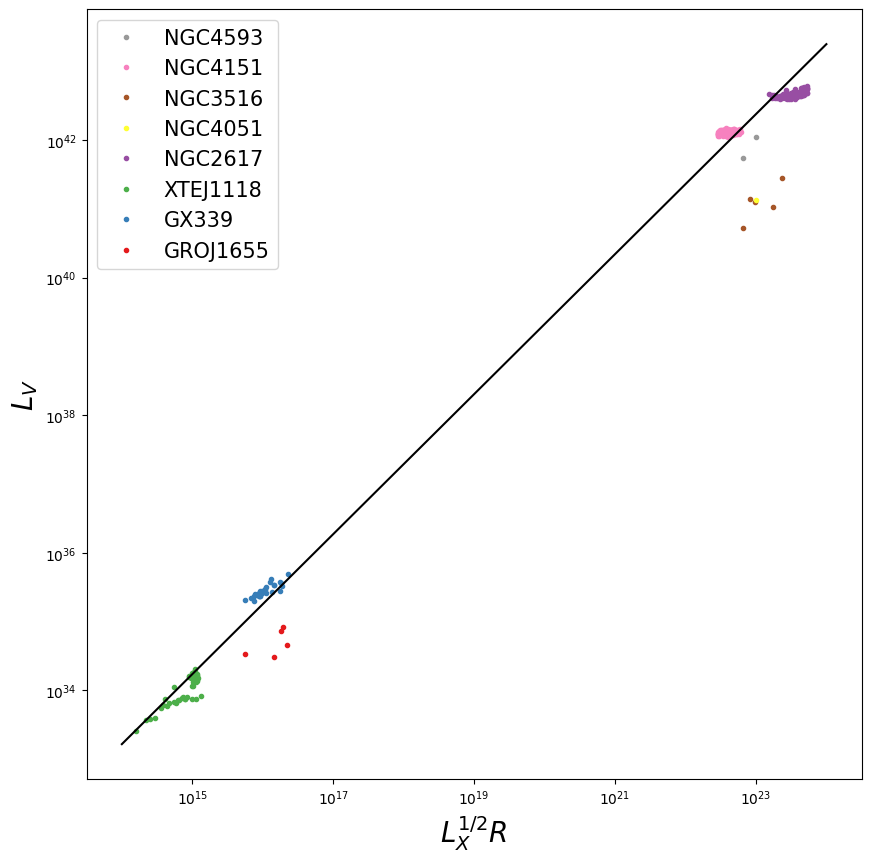

In [ ]:
# AGN
plt.plot(n4593["sqrt(L_x) a"], n4593["L_opt"], ".", c=colors[7], label="NGC4593")
plt.plot(n4151["sqrt(L_x) a"], n4151["L_opt"], ".", c=colors[6], label="NGC4151")
plt.plot(n3516["sqrt(L_x) a"], n3516["L_opt"], ".", c=colors[5], label="NGC3516")
plt.plot(n4051["sqrt(L_x) a"], n4051["L_opt"], ".", c=colors[4], label="NGC4051")
plt.plot(n2617["sqrt(L_x) a"], n2617["L_opt"], ".", c=colors[3], label="NGC2617")

# XRBs
plt.plot(xtej["sqrt(L_x) a"], xtej["L_opt"], ".", c=colors[2], label="XTEJ1118")
plt.plot(gx["sqrt(L_x) a"], gx["L_opt"], ".", c=colors[1], label="GX339")
plt.plot(groj["sqrt(L_x) a"], groj["L_opt"], ".", c=colors[0], label="GROJ1655")


# info
plt.legend(fontsize=15)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$L_X^{1/2} R$", fontsize=20)
plt.ylabel(r"$L_{V}$", fontsize=20)


# fitting
logA = np.log10(df["sqrt(L_x) a"])
logB = np.log10(df["L_opt"])

a, b = np.polyfit(logA, logB, 1)


xfit = np.logspace(14, 24, 100)


def function(x, a, b):
    return 10 ** (b) * x ** (a)


plt.plot(xfit, function(xfit, a, b), c="black")

a, b  # exactly the same as the excel result

(1.1009358931726025, -5.532688750288604)

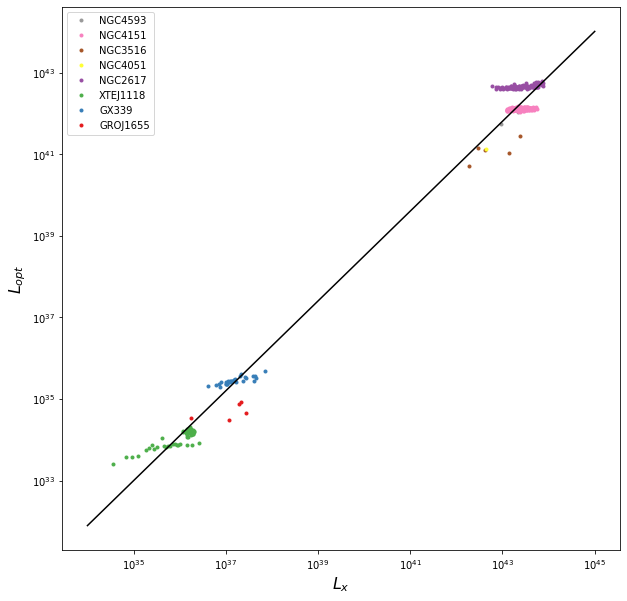

In [ ]:
# AGN
plt.plot(n4593["L_x"], n4593["L_opt"], ".", c=colors[7], label="NGC4593")
plt.plot(n4151["L_x"], n4151["L_opt"], ".", c=colors[6], label="NGC4151")
plt.plot(n3516["L_x"], n3516["L_opt"], ".", c=colors[5], label="NGC3516")
plt.plot(n4051["L_x"], n4051["L_opt"], ".", c=colors[4], label="NGC4051")
plt.plot(n2617["L_x"], n2617["L_opt"], ".", c=colors[3], label="NGC2617")

# XRBs
plt.plot(xtej["L_x"], xtej["L_opt"], ".", c=colors[2], label="XTEJ1118")
plt.plot(gx["L_x"], gx["L_opt"], ".", c=colors[1], label="GX339")
plt.plot(groj["L_x"], groj["L_opt"], ".", c=colors[0], label="GROJ1655")


# info
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$L_x$", fontsize=16)
plt.ylabel(r"$L_{opt}$", fontsize=16)


# fitting
logC = np.log10(df["L_x"])
logD = np.log10(df["L_opt"])

c, d = np.polyfit(logC, logD, 1)


xfit = np.logspace(34, 45, 100)


def function(x, c, d):
    return 10 ** (d) * x ** (c)


plt.plot(xfit, function(xfit, c, d), c="black")

c, d  # exactly the same as the excel result

(1.0173048495838926, 18.97793516802148)

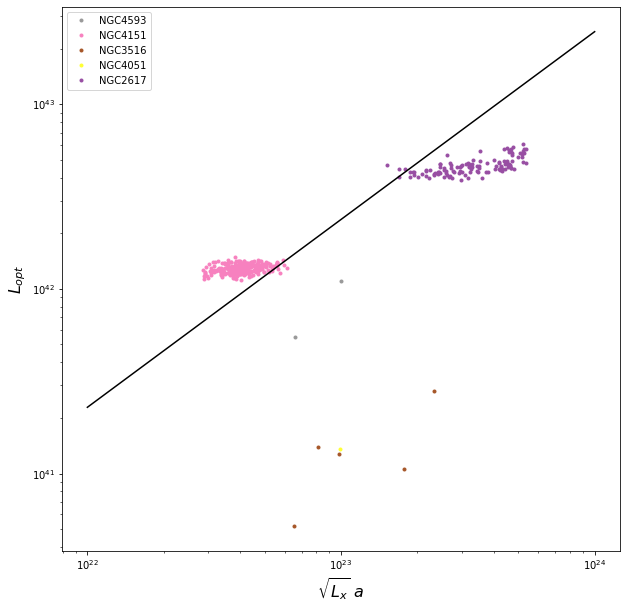

In [ ]:
# AGN
plt.plot(n4593["sqrt(L_x) a"], n4593["L_opt"], ".", c=colors[7], label="NGC4593")
plt.plot(n4151["sqrt(L_x) a"], n4151["L_opt"], ".", c=colors[6], label="NGC4151")
plt.plot(n3516["sqrt(L_x) a"], n3516["L_opt"], ".", c=colors[5], label="NGC3516")
plt.plot(n4051["sqrt(L_x) a"], n4051["L_opt"], ".", c=colors[4], label="NGC4051")
plt.plot(n2617["sqrt(L_x) a"], n2617["L_opt"], ".", c=colors[3], label="NGC2617")

# XRBs
# plt.plot(xtej['sqrt(L_x) a'], xtej['L_opt'],   '.', c=colors[2], label='XTEJ1118')
# plt.plot(gx['sqrt(L_x) a'], gx['L_opt'],       '.', c=colors[1], label='GX339')
# plt.plot(groj['sqrt(L_x) a'], groj['L_opt'],   '.', c=colors[0], label='GROJ1655')


# info
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\sqrt{L_x} \ a$", fontsize=16)
plt.ylabel(r"$L_{opt}$", fontsize=16)


# fitting
logA = np.log10(df["sqrt(L_x) a"])
logB = np.log10(df["L_opt"])

a, b = np.polyfit(logA, logB, 1)


xfit = np.logspace(22, 24, 100)


def function(x, a, b):
    return 10 ** (b) * x ** (a)


plt.plot(xfit, function(xfit, a, b), c="black")

a, b  # exactly the same as the excel result

(1.0173048495838926, 18.97793516802148)

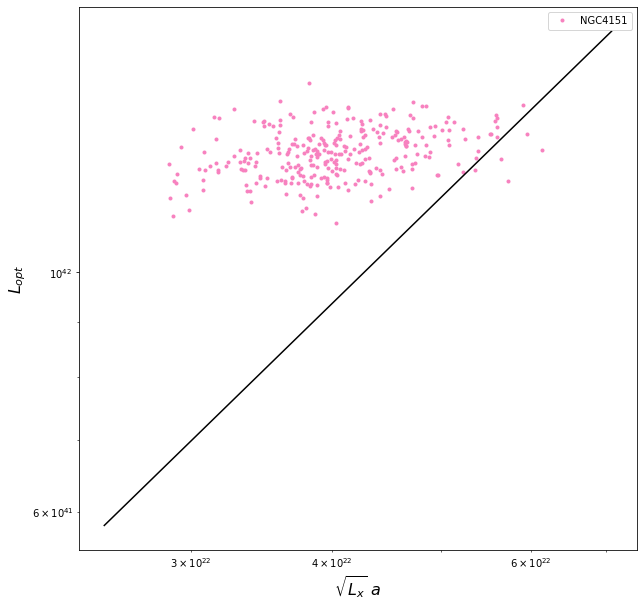

In [ ]:
plt.close()
plt.plot(n4151["sqrt(L_x) a"], n4151["L_opt"], ".", c=colors[6], label="NGC4151")

# info
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\sqrt{L_x} \ a$", fontsize=16)
plt.ylabel(r"$L_{opt}$", fontsize=16)


# fitting
logA = np.log10(df["sqrt(L_x) a"])
logB = np.log10(df["L_opt"])

a, b = np.polyfit(logA, logB, 1)


xfit = np.logspace(22.4, 22.85, 100)


def function(x, a, b):
    return 10 ** (b) * x ** (a)


plt.plot(xfit, function(xfit, a, b), c="black")

a, b  # exactly the same as the excel result

(1.0173048495838926, 18.97793516802148)

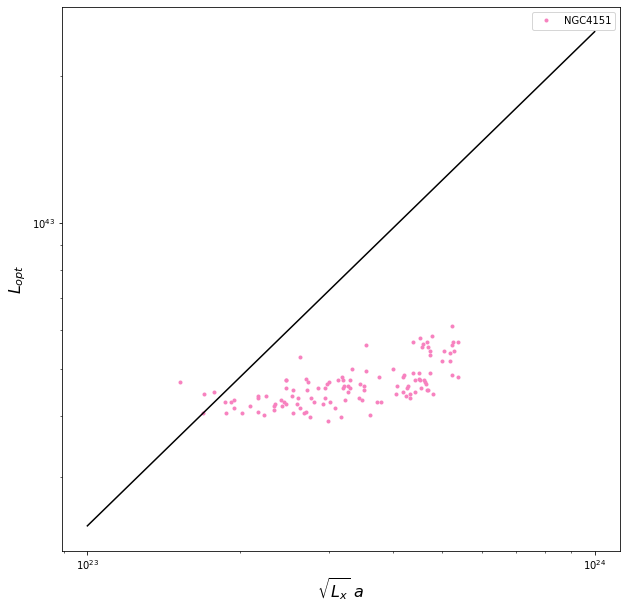

In [ ]:
plt.close()
plt.plot(n2617["sqrt(L_x) a"], n2617["L_opt"], ".", c=colors[6], label="NGC4151")

# info
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\sqrt{L_x} \ a$", fontsize=16)
plt.ylabel(r"$L_{opt}$", fontsize=16)


# fitting
logA = np.log10(df["sqrt(L_x) a"])
logB = np.log10(df["L_opt"])

a, b = np.polyfit(logA, logB, 1)


xfit = np.logspace(23, 24, 100)


def function(x, a, b):
    return 10 ** (b) * x ** (a)


plt.plot(xfit, function(xfit, a, b), c="black")

a, b  # exactly the same as the excel result

## Another Correlation

In [ ]:
f = pd.read_csv(
    "/content/drive/My Drive/Research/NYU Abu Dhabi/correlations/lag-size.csv"
)
# f = f[f['Source']!='Cyg X-2']

f

,Source,type,optical lag (s),+-,ref,Unnamed: 5,M_CO(Mo),+-.1,M_CS(Mo),+-.2,P(hr),+-.3,refs,orb.sep(cm),disc.radius(ls)
0,4U 1735-444,NS LMXB,2.80,0.50000,McClintock.1979,NaN,1.400,0.700,0.448,0.413,4.652004,3.200000e-07,Casares.2006,1.227689e+11,2.250764
1,Ser X-1,NS LMXB,1.40,0.50000,Hackwell.1979,NaN,1.400,0.700,1.000,1.000,2.060000,2.800000e-01,Cornelisse.2013,7.781733e+10,1.426651
2,4U 1636-536,NS LMXB,2.45,0.76092,Matsuoka.1984,NaN,1.400,0.700,0.430,0.280,3.793126,1.600000e-07,Casares.2006,1.068013e+11,1.958023
3,GS 1826-24,NS LMXB,3.00,1.00000,Kong.2000,NaN,1.400,0.700,1.000,1.000,2.249400,1.500000e-04,Meshcheryakov.2010,8.251685e+10,1.512809
4,EXO 0748-676,NS LMXB,3.61,0.69000,Hynes.2006,NaN,1.400,0.700,0.290,0.130,3.823944,2.880000e-04,Hynes.Jones.2009,1.045677e+11,1.917075
5,Sco X-1,NS LMXB,8.60,1.30000,McGowan.2003,NaN,1.400,0.700,0.950,0.550,18.895517,1.200000e-05,Wang.2018,3.386021e+11,6.207704
6,LMC X-2,NS LMXB,10.20,5.80000,McGowan.2003,NaN,1.400,0.700,1.000,1.000,7.680000,4.800000e-01,Cornelisse.2007,1.870994e+11,3.430155
7,Cyg X-2,NS LMXB,2.00,2.00000,Durant.2011,NaN,1.670,0.220,0.560,0.070,236.274384,1.752000e-03,Premachandra.2016,1.792561e+12,32.863610
8,PSR J1023+0038,NS LMXB,5.00,5.00000,Shahbaz.2018,NaN,1.710,0.160,0.240,0.100,4.754309,2.400000e-05,"Deller.12, Archibald.09",1.270000e+11,2.320000
9,XTE J1118+480,BH LMXB,3.00,3.00000,Hynes.2006,NaN,7.300,0.700,0.180,0.070,4.078414,5.000000e-06,Saikia.2019.and.refs.therein,1.792211e+11,3.285721


In [ ]:
f = f[f["Source"] != "Cyg X-2"]
f

,Source,type,optical lag (s),+-,ref,Unnamed: 5,M_CO(Mo),+-.1,M_CS(Mo),+-.2,P(hr),+-.3,refs,orb.sep(cm),disc.radius(ls)
0,4U 1735-444,NS LMXB,2.80,0.50000,McClintock.1979,NaN,1.400,0.700,0.448,0.413,4.652004,3.200000e-07,Casares.2006,1.227689e+11,2.250764
1,Ser X-1,NS LMXB,1.40,0.50000,Hackwell.1979,NaN,1.400,0.700,1.000,1.000,2.060000,2.800000e-01,Cornelisse.2013,7.781733e+10,1.426651
2,4U 1636-536,NS LMXB,2.45,0.76092,Matsuoka.1984,NaN,1.400,0.700,0.430,0.280,3.793126,1.600000e-07,Casares.2006,1.068013e+11,1.958023
3,GS 1826-24,NS LMXB,3.00,1.00000,Kong.2000,NaN,1.400,0.700,1.000,1.000,2.249400,1.500000e-04,Meshcheryakov.2010,8.251685e+10,1.512809
4,EXO 0748-676,NS LMXB,3.61,0.69000,Hynes.2006,NaN,1.400,0.700,0.290,0.130,3.823944,2.880000e-04,Hynes.Jones.2009,1.045677e+11,1.917075
5,Sco X-1,NS LMXB,8.60,1.30000,McGowan.2003,NaN,1.400,0.700,0.950,0.550,18.895517,1.200000e-05,Wang.2018,3.386021e+11,6.207704
6,LMC X-2,NS LMXB,10.20,5.80000,McGowan.2003,NaN,1.400,0.700,1.000,1.000,7.680000,4.800000e-01,Cornelisse.2007,1.870994e+11,3.430155
8,PSR J1023+0038,NS LMXB,5.00,5.00000,Shahbaz.2018,NaN,1.710,0.160,0.240,0.100,4.754309,2.400000e-05,"Deller.12, Archibald.09",1.270000e+11,2.320000
9,XTE J1118+480,BH LMXB,3.00,3.00000,Hynes.2006,NaN,7.300,0.700,0.180,0.070,4.078414,5.000000e-06,Saikia.2019.and.refs.therein,1.792211e+11,3.285721
10,GX 339-4,BH LMXB,10.00,5.00000,Gandhi.2010,NaN,5.900,3.600,1.060,0.650,42.140000,1.000000e-02,Saikia.2019.and.refs.therein,8.300302e+11,15.217220


### New Analysis

#### Objectives
- Plot the data
- Plot the error bar
- Put the linear fitting function and check

In [ ]:
f = f[f["Source"] != "Cyg X-2"]
f
x = np.array(f["disc.radius(ls)"])
y = np.array(f["optical lag (s)"])
yerr = np.array(f["+-"])
labels = np.array(f["Source"])

[0.80885742 0.15540685]


Text(0, 0.5, 'Optical lag (s)')

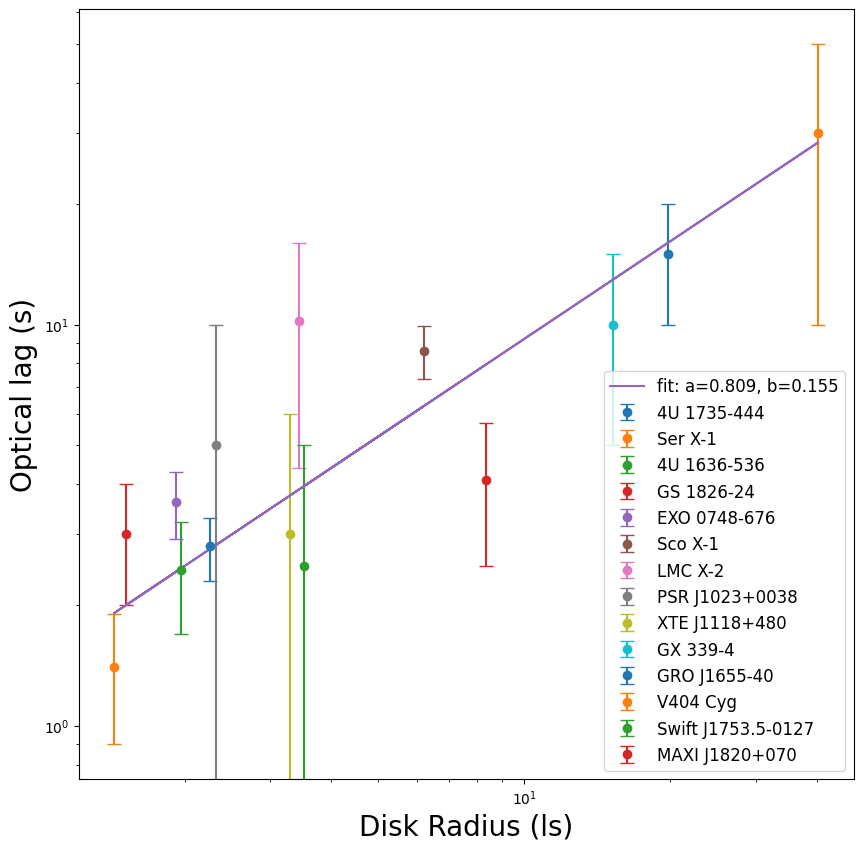

In [ ]:
for i in range(len(x)):
    # print(f['Source'][i])
    plt.errorbar(x[i], y[i], yerr=yerr[i], label=labels[i], capsize=5, fmt="o")

xfit = np.logspace(0, 2.1, 100)


def func(x, a, b):
    return 10 ** (b) * x ** (a)


popt, pcov = curve_fit(func, x, y)
print(popt)
plt.plot(x, func(x, *popt), "-", label="fit: a=%5.3f, b=%5.3f" % tuple(popt))

# info
plt.legend(fontsize=12)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Disk Radius (ls)", fontsize=20)
plt.ylabel("Optical lag (s)", fontsize=20)

### Previous Code (Non-linear Regression)

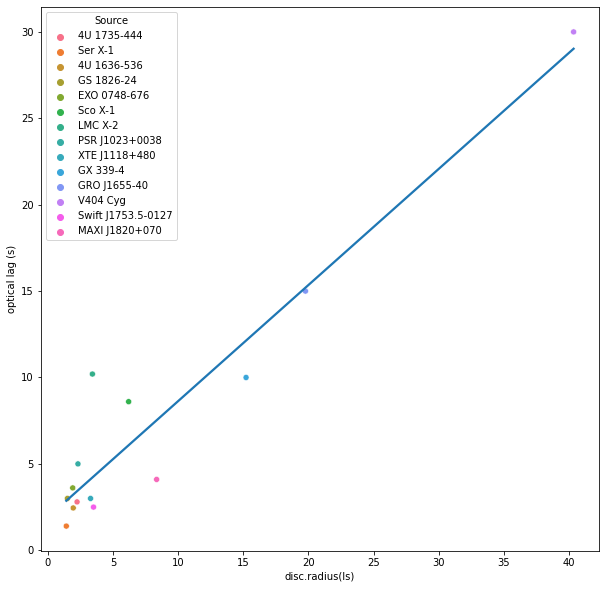

In [ ]:
sns.regplot(x="disc.radius(ls)", y="optical lag (s)", scatter=False, ci=None, data=f)
sns.scatterplot(x="disc.radius(ls)", y="optical lag (s)", data=f, hue="Source")

<ErrorbarContainer object of 3 artists>

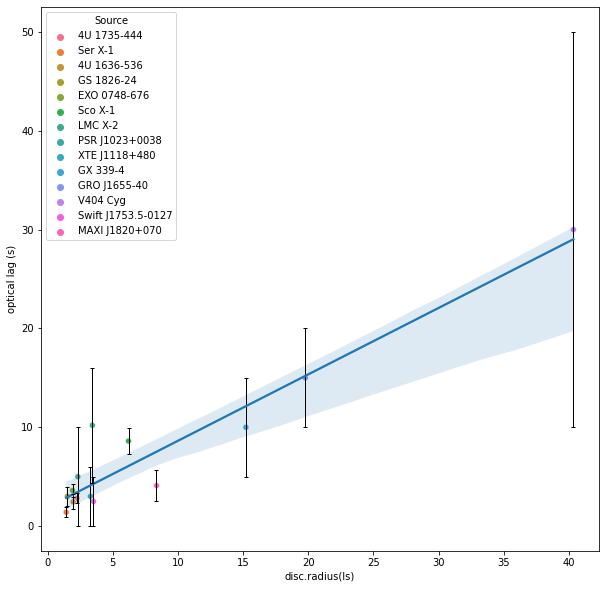

In [ ]:
sns.scatterplot(x="disc.radius(ls)", y="optical lag (s)", c="b", data=f, hue="Source")
sns.regplot(x="disc.radius(ls)", y="optical lag (s)", scatter=False, ci=95, data=f)
x = f["disc.radius(ls)"]
dy = f["+-"]
y = f["optical lag (s)"]
plt.errorbar(x, y, yerr=dy, c="black", fmt="none", elinewidth=1, capsize=2)

### Without Cyg X-2

In [ ]:
# without Cyg X-2
f = f[f["Source"] != "Cyg X-2"]
f

,Source,type,optical lag (s),+-,ref,Unnamed: 5,M_CO(Mo),+-.1,M_CS(Mo),+-.2,P(hr),+-.3,refs,orb.sep(cm),disc.radius(ls)
0,4U 1735-444,NS LMXB,2.80,0.50000,McClintock.1979,NaN,1.400,0.700,0.448,0.413,4.652004,3.200000e-07,Casares.2006,1.227689e+11,2.250764
1,Ser X-1,NS LMXB,1.40,0.50000,Hackwell.1979,NaN,1.400,0.700,1.000,1.000,2.060000,2.800000e-01,Cornelisse.2013,7.781733e+10,1.426651
2,4U 1636-536,NS LMXB,2.45,0.76092,Matsuoka.1984,NaN,1.400,0.700,0.430,0.280,3.793126,1.600000e-07,Casares.2006,1.068013e+11,1.958023
3,GS 1826-24,NS LMXB,3.00,1.00000,Kong.2000,NaN,1.400,0.700,1.000,1.000,2.249400,1.500000e-04,Meshcheryakov.2010,8.251685e+10,1.512809
4,EXO 0748-676,NS LMXB,3.61,0.69000,Hynes.2006,NaN,1.400,0.700,0.290,0.130,3.823944,2.880000e-04,Hynes.Jones.2009,1.045677e+11,1.917075
5,Sco X-1,NS LMXB,8.60,1.30000,McGowan.2003,NaN,1.400,0.700,0.950,0.550,18.895517,1.200000e-05,Wang.2018,3.386021e+11,6.207704
6,LMC X-2,NS LMXB,10.20,5.80000,McGowan.2003,NaN,1.400,0.700,1.000,1.000,7.680000,4.800000e-01,Cornelisse.2007,1.870994e+11,3.430155
8,PSR J1023+0038,NS LMXB,5.00,5.00000,Shahbaz.2018,NaN,1.710,0.160,0.240,0.100,4.754309,2.400000e-05,"Deller.12, Archibald.09",1.270000e+11,2.320000
9,XTE J1118+480,BH LMXB,3.00,3.00000,Hynes.2006,NaN,7.300,0.700,0.180,0.070,4.078414,5.000000e-06,Saikia.2019.and.refs.therein,1.792211e+11,3.285721
10,GX 339-4,BH LMXB,10.00,5.00000,Gandhi.2010,NaN,5.900,3.600,1.060,0.650,42.140000,1.000000e-02,Saikia.2019.and.refs.therein,8.300302e+11,15.217220


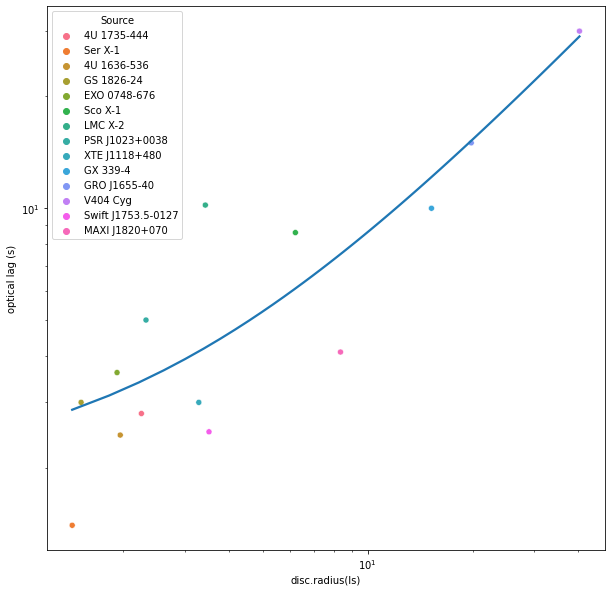

In [ ]:
sns.regplot(x="disc.radius(ls)", y="optical lag (s)", scatter=False, ci=None, data=f)
sns.scatterplot(x="disc.radius(ls)", y="optical lag (s)", data=f, hue="Source")
plt.xscale("log")


plt.yscale("log")

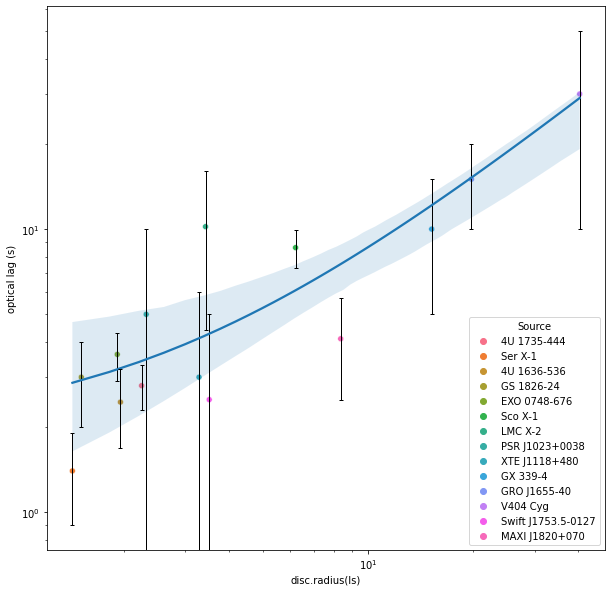

In [ ]:
x = f["disc.radius(ls)"]
dy = f["+-"]
y = f["optical lag (s)"]
sns.scatterplot(x="disc.radius(ls)", y="optical lag (s)", c="b", data=f, hue="Source")
sns.regplot(x="disc.radius(ls)", y="optical lag (s)", scatter=False, ci=95, data=f)

plt.errorbar(x, y, yerr=dy, c="black", fmt="none", elinewidth=1, capsize=2)
plt.xscale("log")
plt.yscale("log")